# ConvNeXt-Tiny - Waste Classification
## PyTorch Implementation (Mac/MPS)

**Model:** ConvNeXt-Tiny (ImageNet pretrained)

**Objective:** Compare performance between preprocessed and raw datasets

**Hardware:** MacBook Air M4 (MPS) / Windows RTX 3060 Ti (CUDA)

**Classes:** aluminium, paper, plastic

---
## 1. Import Libraries and Setup

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ConvNeXt_Tiny_Weights

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Import custom logger
sys.path.append('..')
from result_logger import log_result

# Device configuration (auto-detect MPS/CUDA/CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print("PyTorch version:", torch.__version__)
print("Device:", device)

---
## 2. Dataset Paths Configuration
Define all dataset paths as constants

In [ ]:
# Dataset Configuration
CLASSES = ['aluminium', 'paper', 'plastic']
NUM_CLASSES = 3
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4  # Adjust based on your system

# Set A: Preprocessed Public (Training Data)
PREPROCESSED_TRAIN = r"../Dataset/preprocessed_Public/train"
PREPROCESSED_VAL = r"../Dataset/preprocessed_Public/val"
PREPROCESSED_TEST_PUBLIC = r"../Dataset/preprocessed_Public/test"

# Set B: Preprocessed Self-Collected (Final Testing)
PREPROCESSED_TEST_SELF = r"../Dataset/preprocessed_self/test"

# Set C: Raw Data (For Comparison)
RAW_PUBLIC = r"../Dataset/Public_dataset"
RAW_SELF = r"../Dataset/SelfCollected_Dataset"

# Create results directory
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("✓ Paths configured successfully")

---
## 3. Data Transforms Setup
Define transformations with ImageNet normalization

In [ ]:
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("✓ Data transforms defined")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Normalization: ImageNet (mean={IMAGENET_MEAN}, std={IMAGENET_STD})")

---
## 4. DataLoader Creation Function
Create PyTorch DataLoaders

In [ ]:
def create_dataloaders(train_path, val_path, test_path):
    """
    Create PyTorch DataLoaders for training, validation, and testing
    
    Args:
        train_path: Path to training data
        val_path: Path to validation data
        test_path: Path to test data
    
    Returns:
        train_loader, val_loader, test_loader
    """
    
    # Load datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
    test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    print(f"\nDataset sizes:")
    print(f"  Training:   {len(train_dataset)} images")
    print(f"  Validation: {len(val_dataset)} images")
    print(f"  Testing:    {len(test_dataset)} images")
    print(f"  Classes: {train_dataset.classes}")
    
    return train_loader, val_loader, test_loader

print("✓ DataLoader creation function defined")

---
## 5. Model Architecture
Build ConvNeXt-Tiny with custom classifier

In [ ]:
def build_convnext_tiny_model():
    """
    Build ConvNeXt-Tiny model with custom classification head
    
    Returns:
        PyTorch model
    """
    
    # Load pretrained ConvNeXt-Tiny
    weights = ConvNeXt_Tiny_Weights.DEFAULT
    model = models.convnext_tiny(weights=weights)
    
    # Get the number of input features for the classifier
    num_features = model.classifier[2].in_features
    
    # Replace classifier with custom head
    model.classifier = nn.Sequential(
        nn.Flatten(1),
        nn.LayerNorm(num_features, eps=1e-6),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )
    
    model = model.to(device)
    
    return model

print("✓ Model architecture function defined")

---
## 6. Training Function
Complete training pipeline with validation

In [ ]:
def train_model(model, train_loader, val_loader, model_name, epochs=30):
    """
    Train the PyTorch model
    
    Args:
        model: PyTorch model
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        model_name: Name for saving the model
        epochs: Number of training epochs
    
    Returns:
        Training history dictionary
    """
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    patience_limit = 10
    
    print(f"\n{'='*60}")
    print(f"Training ConvNeXt-Tiny")
    print(f"{'='*60}\n")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]  ')
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })
        
        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        
        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        # Learning rate scheduler
        scheduler.step(epoch_val_loss)
        
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}")
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), f'models/{model_name}.pth')
            print(f"  ✓ Best model saved (Val Acc: {best_val_acc:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience_limit:
            print(f"\n  Early stopping triggered after {epoch+1} epochs")
            break
        
        print()
    
    # Load best model
    model.load_state_dict(torch.load(f'models/{model_name}.pth'))
    print(f"\n✓ Training completed. Best Val Acc: {best_val_acc:.4f}")
    
    return history

print("✓ Training function defined")

---
## 7. Evaluation Function
Evaluate model and generate metrics

In [ ]:
def evaluate_model(model, test_loader, experiment_name):
    """
    Evaluate model and display results
    
    Args:
        model: Trained PyTorch model
        test_loader: Test DataLoader
        experiment_name: Name of the experiment
    
    Returns:
        Dictionary with evaluation metrics
    """
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {experiment_name}")
    print(f"{'='*60}\n")
    
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))
    
    # Display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix - {experiment_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"Results Summary - {experiment_name}")
    print(f"{'='*60}")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"{'='*60}\n")
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("✓ Evaluation function defined")

---
## 8. Experiment 1: Preprocessed Dataset
Train on preprocessed public data, test on preprocessed self-collected data

In [ ]:
print("\n" + "#"*60)
print("# EXPERIMENT 1: PREPROCESSED DATASET")
print("#"*60 + "\n")

# Create dataloaders
train_loader_prep, val_loader_prep, test_loader_prep = create_dataloaders(
    PREPROCESSED_TRAIN,
    PREPROCESSED_VAL,
    PREPROCESSED_TEST_SELF
)

# Build model
model_prep = build_convnext_tiny_model()
print(f"\nModel: ConvNeXt-Tiny")
print(f"Total parameters: {sum(p.numel() for p in model_prep.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_prep.parameters() if p.requires_grad):,}")

# Train model
history_prep = train_model(
    model_prep,
    train_loader_prep,
    val_loader_prep,
    model_name='convnext_tiny_preprocessed',
    epochs=30
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_prep['train_acc'], label='Train Accuracy')
axes[0].plot(history_prep['val_acc'], label='Val Accuracy')
axes[0].set_title('Model Accuracy - Preprocessed')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_prep['train_loss'], label='Train Loss')
axes[1].plot(history_prep['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss - Preprocessed')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
results_prep = evaluate_model(model_prep, test_loader_prep, "ConvNeXt-Tiny - Preprocessed")

# Log results
log_result(
    model_name='ConvNeXt-Tiny',
    experiment_type='Preprocessed',
    accuracy=results_prep['accuracy'],
    precision=results_prep['precision'],
    recall=results_prep['recall'],
    f1=results_prep['f1'],
    loss=results_prep['loss']
)

print("✓ Experiment 1 completed and results logged")

---
## 9. Experiment 2: Raw Dataset
Train on raw public data, test on raw self-collected data

In [ ]:
print("\n" + "#"*60)
print("# EXPERIMENT 2: RAW DATASET")
print("#"*60 + "\n")

# For raw data, we'll use 80-20 split for train-val from RAW_PUBLIC
# We need to create a custom split
from torch.utils.data import random_split

# Load full raw public dataset
raw_public_dataset = datasets.ImageFolder(RAW_PUBLIC, transform=train_transform)
train_size = int(0.8 * len(raw_public_dataset))
val_size = len(raw_public_dataset) - train_size
train_dataset_raw, val_dataset_raw = random_split(
    raw_public_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Update validation dataset transform
val_dataset_raw.dataset.transform = val_test_transform

# Load test dataset
test_dataset_raw = datasets.ImageFolder(RAW_SELF, transform=val_test_transform)

# Create dataloaders
train_loader_raw = DataLoader(
    train_dataset_raw, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
val_loader_raw = DataLoader(
    val_dataset_raw, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader_raw = DataLoader(
    test_dataset_raw, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

print(f"Dataset sizes:")
print(f"  Training:   {len(train_dataset_raw)} images")
print(f"  Validation: {len(val_dataset_raw)} images")
print(f"  Testing:    {len(test_dataset_raw)} images")

# Build new model
model_raw = build_convnext_tiny_model()

# Train model
history_raw = train_model(
    model_raw,
    train_loader_raw,
    val_loader_raw,
    model_name='convnext_tiny_raw',
    epochs=30
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_raw['train_acc'], label='Train Accuracy')
axes[0].plot(history_raw['val_acc'], label='Val Accuracy')
axes[0].set_title('Model Accuracy - Raw')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_raw['train_loss'], label='Train Loss')
axes[1].plot(history_raw['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss - Raw')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
results_raw = evaluate_model(model_raw, test_loader_raw, "ConvNeXt-Tiny - Raw")

# Log results
log_result(
    model_name='ConvNeXt-Tiny',
    experiment_type='Raw',
    accuracy=results_raw['accuracy'],
    precision=results_raw['precision'],
    recall=results_raw['recall'],
    f1=results_raw['f1'],
    loss=results_raw['loss']
)

print("✓ Experiment 2 completed and results logged")

---
## 10. Comparison Summary
Compare results from both experiments

In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Experiment': ['Preprocessed', 'Raw'],
    'Accuracy': [results_prep['accuracy'], results_raw['accuracy']],
    'Precision': [results_prep['precision'], results_raw['precision']],
    'Recall': [results_prep['recall'], results_raw['recall']],
    'F1-Score': [results_prep['f1'], results_raw['f1']],
    'Loss': [results_prep['loss'], results_raw['loss']]
})

print("\n" + "="*80)
print("CONVNEXT-TINY - FINAL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Visualize comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2,
               [results_prep['accuracy'], results_prep['precision'],
                results_prep['recall'], results_prep['f1']],
               width, label='Preprocessed')
bars2 = ax.bar(x + width/2,
               [results_raw['accuracy'], results_raw['precision'],
                results_raw['recall'], results_raw['f1']],
               width, label='Raw')

ax.set_ylabel('Score')
ax.set_title('ConvNeXt-Tiny: Preprocessed vs Raw Dataset')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ All experiments completed successfully!")
print("✓ Models saved in 'models/' directory")
print("✓ Results logged to 'final_results.csv'")

---
## 11. Test Raw Model on Self-Collected Dataset
Load the trained preprocessed model and evaluate on self-collected test data

In [1]:
!pip install torch torchvision pandas matplotlib seaborn scikit-learn tqdm

  Using cached torch-2.10.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (31 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cusolver_cu12-11.7.3.90-py3-none-manylinux_2_27_x86_64.whl.metada

Using CUDA GPU
Device: cuda

############################################################
# TESTING RAW MODEL ON SELF-COLLECTED DATASET
############################################################

✓ Raw model loaded from 'models/convnext_tiny_preprocessed.pth'
Test dataset size: 533 images
Classes: ['aluminium', 'paper', 'plastic']

Evaluating: ConvNeXt-Tiny Raw - Self-Collected Test Set



Testing: 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]



Classification Report:
              precision    recall  f1-score   support

   aluminium       0.54      0.83      0.66       148
       paper       0.69      0.50      0.58       151
     plastic       0.82      0.69      0.75       234

    accuracy                           0.67       533
   macro avg       0.68      0.67      0.66       533
weighted avg       0.70      0.67      0.67       533



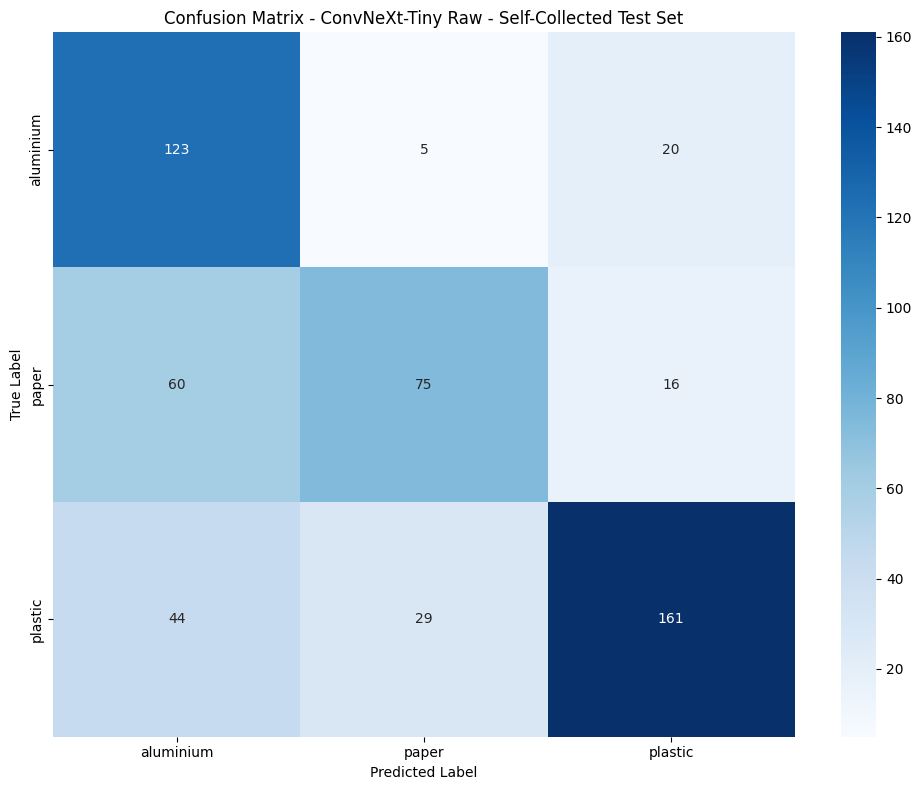


Results Summary - ConvNeXt-Tiny Raw - Self-Collected Test Set
Test Loss:      1.4087
Test Accuracy:  0.6735
Precision:      0.7042
Recall:         0.6735
F1-Score:       0.6736


RAW MODEL - SELF-COLLECTED TEST RESULTS
Test Accuracy:  0.6735
Precision:      0.7042
Recall:         0.6735
F1-Score:       0.6736
Loss:           1.4087

✓ Results logged: ConvNeXt-Tiny - Preprocessed_on_Raw
  Accuracy: 0.6735, Precision: 0.7042, Recall: 0.6735, F1: 0.6736
✓ Results logged to 'final_results.csv'


In [2]:
# Standalone cell - includes all necessary imports and definitions
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ConvNeXt_Tiny_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import custom logger
sys.path.append('..')
from result_logger import log_result

# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Device: {device}")

# Constants
CLASSES = ['aluminium', 'paper', 'plastic']
NUM_CLASSES = 3
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
RAW_SELF = r"../Dataset/SelfCollected_Dataset"

# Validation/Test transform
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Model building function
def build_convnext_tiny_model():
    """Build ConvNeXt-Tiny model with custom classification head"""
    weights = ConvNeXt_Tiny_Weights.DEFAULT
    model = models.convnext_tiny(weights=weights)
    num_features = model.classifier[2].in_features
    model.classifier = nn.Sequential(
        nn.Flatten(1),
        nn.LayerNorm(num_features, eps=1e-6),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )
    model = model.to(device)
    return model

# Evaluation function
def evaluate_model(model, test_loader, experiment_name):
    """Evaluate model and display results"""
    print(f"\n{'='*60}")
    print(f"Evaluating: {experiment_name}")
    print(f"{'='*60}\n")
    
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))
    
    # Display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix - {experiment_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"Results Summary - {experiment_name}")
    print(f"{'='*60}")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"{'='*60}\n")
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Main execution
print("\n" + "#"*60)
print("# TESTING RAW MODEL ON SELF-COLLECTED DATASET")
print("#"*60 + "\n")

# Load the trained raw model
model_raw_test = build_convnext_tiny_model()
# Use map_location to handle cross-device model loading
model_raw_test.load_state_dict(torch.load('models/convnext_tiny_preprocessed.pth', map_location=device))
model_raw_test.eval()
print("✓ Raw model loaded from 'models/convnext_tiny_preprocessed.pth'")

# Create test dataloader for raw self-collected dataset
test_dataset_raw_self = datasets.ImageFolder(RAW_SELF, transform=val_test_transform)
test_loader_raw_self = DataLoader(
    test_dataset_raw_self,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Test dataset size: {len(test_dataset_raw_self)} images")
print(f"Classes: {test_dataset_raw_self.classes}")

# Evaluate the model
results_raw_self = evaluate_model(
    model_raw_test,
    test_loader_raw_self,
    "ConvNeXt-Tiny Raw - Self-Collected Test Set"
)

# Display results
print("\n" + "="*60)
print("RAW MODEL - SELF-COLLECTED TEST RESULTS")
print("="*60)
print(f"Test Accuracy:  {results_raw_self['accuracy']:.4f}")
print(f"Precision:      {results_raw_self['precision']:.4f}")
print(f"Recall:         {results_raw_self['recall']:.4f}")
print(f"F1-Score:       {results_raw_self['f1']:.4f}")
print(f"Loss:           {results_raw_self['loss']:.4f}")
print("="*60 + "\n")

# Log results to CSV
log_result(
    model_name='ConvNeXt-Tiny',
    experiment_type='Preprocessed_on_Raw',
    accuracy=results_raw_self['accuracy'],
    precision=results_raw_self['precision'],
    recall=results_raw_self['recall'],
    f1=results_raw_self['f1'],
    loss=results_raw_self['loss']
)

print("✓ Results logged to 'final_results.csv'")